# Satellite Lake Water Levels

This dataset provides water level measurements for 251 lakes across four continents, derived from satellite radar altimetry. These measurements serve as a cost-effective alternative to traditional ground-based systems and are classified as an Essential Climate Variable (ECV). The data is produced by CLS for the Copernicus Climate Change Service to enhance hydrological and climate monitoring on a continental scale.

**Information on Dataset:**
* Source: [Satellite Lake Water Levels](https://cds.climate.copernicus.eu/datasets/satellite-lake-water-level?tab=overview)
* Author: T. Tewes (City of Konstanz)
* Notebook Version: 1.3 (Updated: December 04, 2024)

## 1. Specifying the paths and working directories

In [1]:
import os

''' ---- Hier die Verzeichnisse angeben ---- '''
download_folder = r".\data\satellite-lake-water-level\download"
working_folder = r".\data\satellite-lake-water-level\working"
geotiff_folder = r".\data\satellite-lake-water-level\geotiff"
csv_folder = r".\data\satellite-lake-water-level\csv"
output_folder = r".\data\satellite-lake-water-level\output"
''' ----- Ende der Eingaben ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Download and Extract Dataset

### 2.1 Authentication

In [2]:
import cdsapi

def main():
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Request Definition and Download

In [3]:
dataset = "satellite-lake-water-level"
request = {
    "variable": "all",
    "region": ["southern_europe"],
    "lake": ["bodensee"]
}

In [4]:
# Uncomment and run this cell to download the dataset:

def main_retrieve():
    dataset_filename = f"{dataset}_bodensee.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)

    # Download the dataset only if the dataset has not been downloaded before
    if not os.path.isfile(dataset_filepath):
        # Download the dataset with the defined request parameters
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Dataset already downloaded.")

if __name__ == "__main__":
    client = main()
    main_retrieve()

2025-01-14 14:05:26,264 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.


2025-01-14 14:05:26,265 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


2025-01-14 14:05:26,266 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**


2025-01-14 14:05:26,267 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


Dataset already downloaded.


### 2.3 Extract Zip folder

In [5]:
import zipfile

# Erstellen Sie den Dateinamen und den Dateipfad für die ZIP-Datei des Datensatzes
dataset_filename = f"{dataset}_bodensee.zip"
dataset_filepath = os.path.join(download_folder, dataset_filename)
extract_folder = working_folder

# Extract the zip file
try:
    if not os.listdir(extract_folder):
        with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Successfully extracted files to: {extract_folder}")
    else:
        print("Folder is not empty. Skipping extraction.")
except FileNotFoundError:
    print(f"Error: The file {dataset_filepath} was not found.")
except zipfile.BadZipFile:
    print(f"Error: The file {dataset_filepath} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Folder is not empty. Skipping extraction.


## 3. Read the netCDF4 file and print the metadata

In [6]:
import netCDF4 as nc

# Open the NetCDF file in read mode
nc_filepath = os.path.join(extract_folder, os.listdir(extract_folder)[0])
dataset = nc.Dataset(nc_filepath, mode='r')

# List all variables in the dataset
variables_list = dataset.variables.keys()
print(f"Available variables: {list(variables_list)}")

Available variables: ['time', 'lat', 'lon', 'water_surface_height_above_reference_datum', 'water_surface_height_uncertainty']


In [7]:
import pandas as pd

variable_name = 'water_surface_height_above_reference_datum'
variable_data = dataset[variable_name]

# Generate summary of the primary variable
summary = {
    "Variable Name": variable_name,
    "Data Type": variable_data.dtype,
    "Shape": variable_data.shape,
    "Variable Info": f"{variable_name}({', '.join(variable_data.dimensions)})",
    "Units": getattr(variable_data, "units", "N/A"),
    "Long Name": getattr(variable_data, "long_name", "N/A"),
}

# Display dataset summary as a DataFrame for better visualization
nc_summary = pd.DataFrame(list(summary.items()), columns=['Description', 'Details'])

# Display the summary DataFrame
nc_summary

,Description,Details
0,Variable Name,water_surface_height_above_reference_datum
1,Data Type,float64
2,Shape,"(101,)"
3,Variable Info,water_surface_height_above_reference_datum(time)
4,Units,m
5,Long Name,water surface height above geoid


## 4. Export as CSV

### 4.1 Create Dataframe and Export as CSV

In [8]:
import netCDF4 as nc

# Funktion zum Umwandeln von netCDF in CSV (nur Zeit und eine Variable)
def netcdf_to_dataframe(nc_file):
    with nc.Dataset(nc_file, more="r") as nc_dataset:
        # Extrahiere die Daten und die Zeit
        time = nc_dataset.variables['time'][:]
        time_units = nc_dataset.variables['time'].units
        time_calendar = getattr(nc_dataset.variables['time'], 'calendar', 'standard')
        cftime = nc.num2date(time, units=time_units, calendar=time_calendar)
        
        # Extract data
        water_surface_height = nc_dataset.variables['water_surface_height_above_reference_datum'][:]
        wsh_units = nc_dataset.variables["water_surface_height_above_reference_datum"].units
        wsh_uncertainity = nc_dataset.variables['water_surface_height_uncertainty'][:]
        
        # Erstelle eine Liste von Einträgen für das DataFrame (nur Zeit und die Variable)
        df = pd.DataFrame(
            {
                "Time": cftime,
                f"Water Surface Height ({wsh_units})": water_surface_height,
                f"Uncertainty": wsh_uncertainity,
            }
        )
       
        # Setze den Index auf die Zeit
        return df.set_index('Time')

# Rufe die Funktion auf und erhalte das DataFrame
df = netcdf_to_dataframe(nc_filepath)

# Generate the output file path
csv_filename = 'satellite-lake-water-level.csv'
csv_path = os.path.join(csv_folder, csv_filename)

# Export the pivot table to CSV if it doesn't already exist
if not os.path.isfile(csv_path):
    df.to_csv(csv_path)
    print(f"Summary data exported to {csv_path}")
else:
    print(f"{csv_path} file already exists. Skipping export.")

# Display the DataFrame
df.head()

.\data\satellite-lake-water-level\csv\satellite-lake-water-level.csv file already exists. Skipping export.


,Water Surface Height (m),Uncertainty
Time,,
2016-03-23 20:43:59.997482,394.44,0.29
2016-04-19 20:43:59.997482,394.62,0.49
2016-05-16 20:44:59.998284,395.41,0.21
2016-06-12 20:44:59.998284,395.72,0.58
2016-07-09 20:44:59.998284,396.13,0.13


## 5 Analyse und Visualisierung

### 5.1 Visualisierung aller Daten (Ohne Karte)

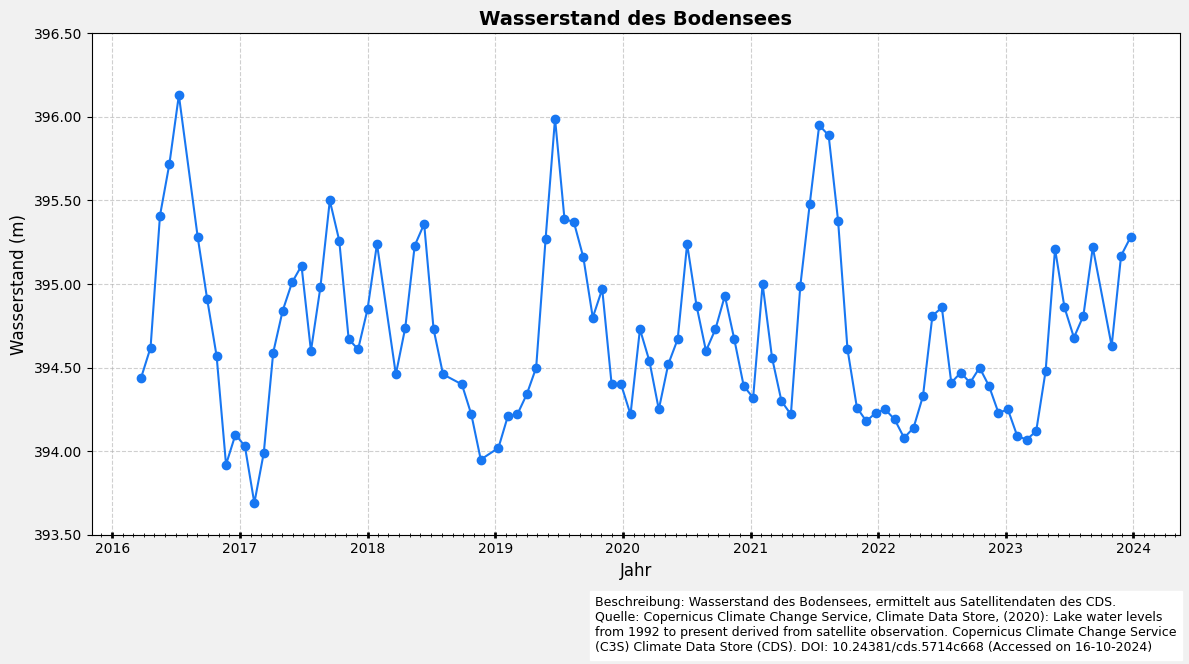

In [9]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
import matplotlib.ticker as ticker
from datetime import datetime

# Function to convert cftime to datetime
def cftime_to_datetime(times):
    return [datetime(t.year, t.month, t.day, t.hour, t.minute, t.second) for t in times]

# Preprocess the data (convert cftime to datetime if necessary)
df.index = cftime_to_datetime(df.index)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

# Plot the data
ax.plot(
    df.index,
    df['Water Surface Height (m)'],
    marker='o',
    linestyle='-',
    color='#1877F2',
    label="Wasserstand",
)

# Format the axis
ax.xaxis.set_major_locator(YearLocator())  # Major ticks for each year
ax.xaxis.set_minor_locator(MonthLocator())  # Minor ticks for each month
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2)
ax.tick_params(axis='x', which='minor', length=3, direction='inout')

# Set y-axis limit
ax.set_ylim(393.5, 396.5)

# Set axis labels and title
ax.set_xlabel('Jahr', fontsize=12)
ax.set_ylabel('Wasserstand (m)', fontsize=12)
ax.set_title('Wasserstand des Bodensees', fontsize=14, fontweight='bold')

# Add grid
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add description and source
plt.figtext(
    0.5,
    -0.05,
    (
        'Beschreibung: Wasserstand des Bodensees, ermittelt aus Satellitendaten des CDS.\n'
        'Quelle: Copernicus Climate Change Service, Climate Data Store, (2020): Lake water levels from 1992 '
        'to present derived from satellite observation. Copernicus Climate Change Service (C3S) Climate Data '
        'Store (CDS). DOI: 10.24381/cds.5714c668 (Accessed on 16-10-2024)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### 5.2 Visualisierung der Monatsdurchschnitte (ohne Karte)

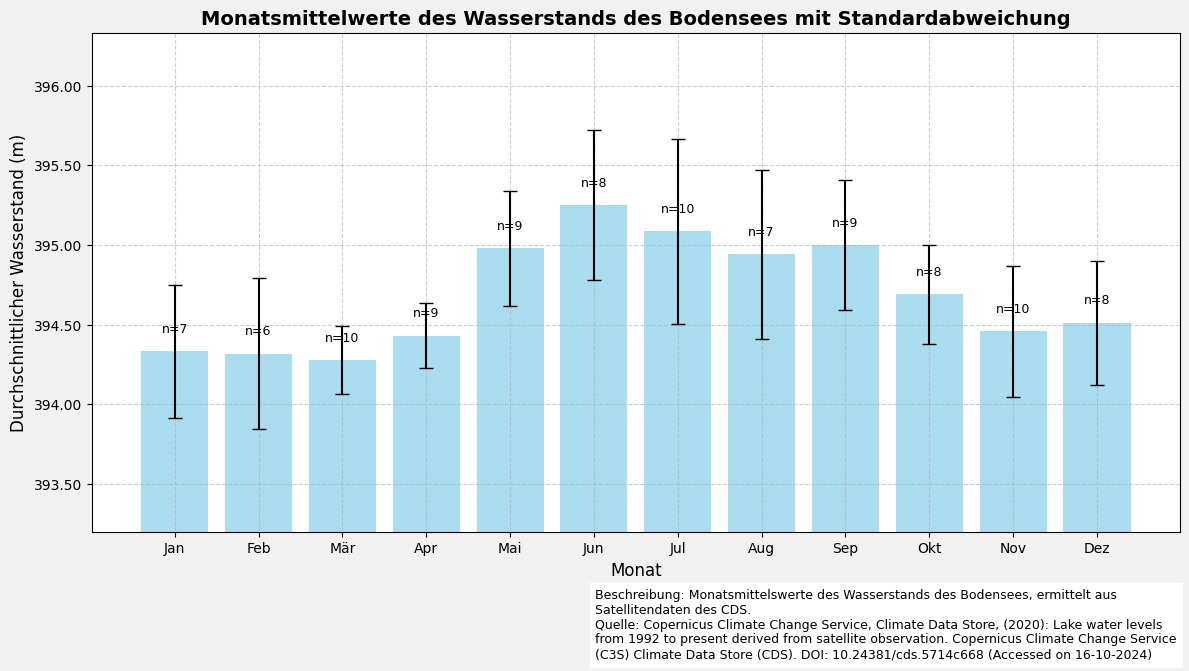

In [10]:
# Gruppiere die Daten nach Monat und berechne den Mittelwert, die Standardabweichung und den Stichprobenumfang
monthly_data = df.assign(month=df.index.month).groupby('month')['Water Surface Height (m)']
monthly_mean = monthly_data.mean()
monthly_std = monthly_data.std()
monthly_n = monthly_data.count()

# Erstelle die Balkenbreite
month_labels = ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']
months = range(1, 13)

# Erstelle das Balkendiagramm
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

# Balkenplot mit Standardabweichung als Fehlerbalken
bars = ax.bar(
    months, 
    monthly_mean, 
    yerr=monthly_std, 
    capsize=5, 
    color='skyblue', 
    alpha=0.7, 
    error_kw=dict(ecolor='black', lw=1.5)
)

# Setze den Bereich der Y-Achse von 390 bis 405
y_min = max(0, monthly_mean.min() - monthly_std.max() - 0.5)
y_max = monthly_mean.max() + monthly_std.max() + 0.5
ax.set_ylim(y_min, y_max)

# Setze die Achsentitel und die Diagrammüberschrift
ax.set_xlabel('Monat', fontsize=12)
ax.set_ylabel('Durchschnittlicher Wasserstand (m)', fontsize=12)
ax.set_title('Monatsmittelwerte des Wasserstands des Bodensees mit Standardabweichung', fontsize=14, fontweight='bold')

# Setze die X-Achsenbeschriftungen (1 = Januar, 12 = Dezember)
ax.set_xticks(months)
ax.set_xticklabels(month_labels)

# Füge den Stichprobenumfang n über den Balken hinzu
for bar, n in zip(bars, monthly_n):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.1,  # Adjusted to dynamically place above bar
        f'n={n}',
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )
    
# Füge ein Gitternetz hinzu
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Beschreibung und Quelle hinzufügen
plt.figtext(0.5, -0.05, 
            'Beschreibung: Monatsmittelswerte des Wasserstands des Bodensees, ermittelt aus Satellitendaten des CDS.\n'
            'Quelle: Copernicus Climate Change Service, Climate Data Store, (2020): Lake water levels from 1992 to present derived from satellite observation. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.5714c668 (Accessed on 16-10-2024)', 
            ha='left', va='center', fontsize=9, wrap=True, backgroundcolor='w')

# Zeige das Diagramm an
plt.tight_layout()
plt.show()


### 5.3 Visualisierung aller Daten (mit Karte)

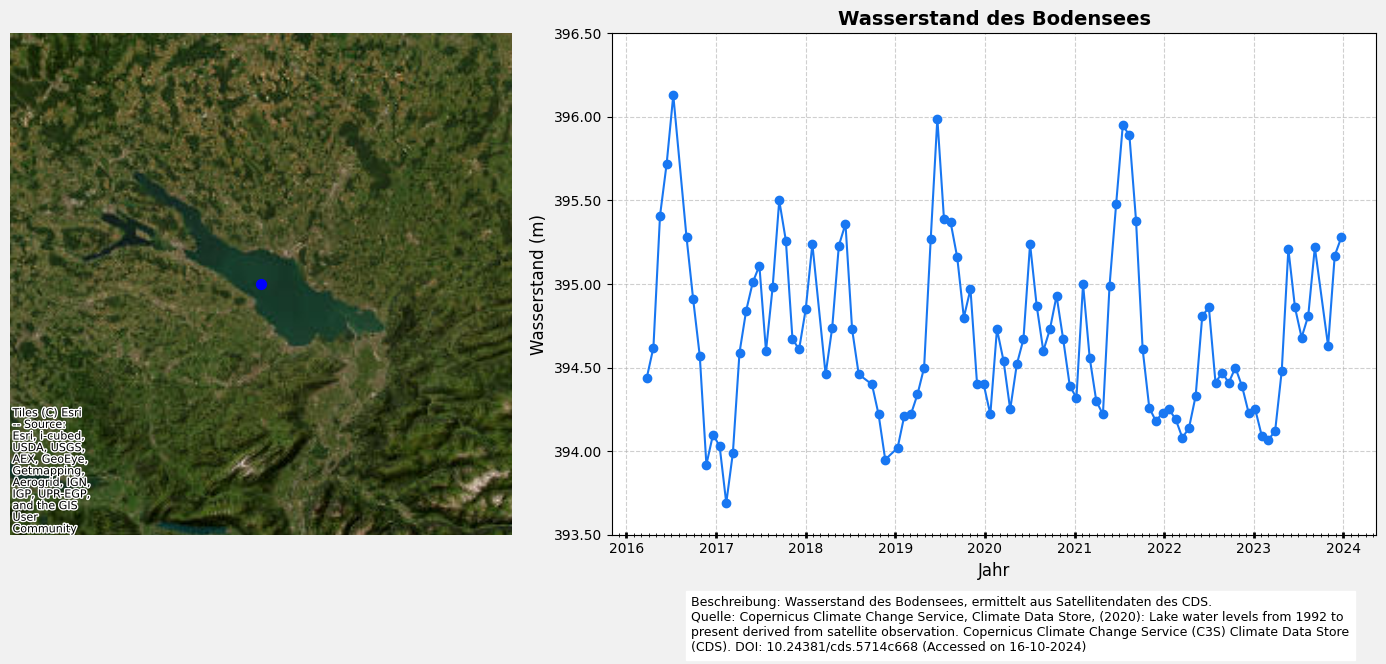

In [11]:
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx 

# Function to convert cftime to datetime
def cftime_to_datetime(times):
    return [datetime(t.year, t.month, t.day, t.hour, t.minute, t.second) for t in times]

# Preprocess the data (convert cftime to datetime if necessary)
df.index = cftime_to_datetime(df.index)

# Definiere den Punkt für den Bodensee (ca. Koordinaten)
bodensee_point = Point(dataset['lon'][:][0], dataset['lat'][:][0])

# Erstelle ein GeoDataFrame mit dem Bodensee-Punkt
lake_bodensee = gpd.GeoDataFrame(
    {'geometry': [bodensee_point]},
    crs='EPSG:4326'  # WGS84-Koordinatensystem
)

# Projiziere in das Web Mercator-Koordinatensystem
lake_bodensee = lake_bodensee.to_crs(epsg=3857)

# Create the figure and axes
fig, axs = plt.subplots(1,2, figsize=(14, 6), facecolor='#f1f1f1', edgecolor='k', gridspec_kw={'width_ratios': [1, 1.5]})

# --- 1. Karte des Bodensees ---
ax = axs[0]
lake_bodensee.plot(ax=ax, color='blue', markersize=50)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)  # Satellitenbild

# Passe den sichtbaren Bereich an (weiter herauszoomen)
# Erhöhe den Bereich für mehr Umgebung (hier auf 100 km in jede Richtung)
ax.set_xlim(lake_bodensee.geometry.x.min() - 80000, lake_bodensee.geometry.x.max() + 80000)  # Vergrößere den Bereich in x-Richtung
ax.set_ylim(lake_bodensee.geometry.y.min() - 80000, lake_bodensee.geometry.y.max() + 80000)  # Vergrößere den Bereich in y-Richtung

#ax1.set_title("Bodensee (Satellitenbild)")
ax.set_axis_off()  # Achsenbeschriftungen entfernen

# --- 2. Diagramm des Wasserstands ---
ax = axs[1]
# Plot the data
ax.plot(
    df.index,
    df['Water Surface Height (m)'],
    marker='o',
    linestyle='-',
    color='#1877F2',
    label="Wasserstand",
)

# Format the x-axis
ax.xaxis.set_major_locator(YearLocator())  # Major ticks for each year
ax.xaxis.set_minor_locator(MonthLocator())  # Minor ticks for each month
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2)
ax.tick_params(axis='x', which='minor', length=3, direction='inout')

# Set y-axis limit
ax.set_ylim(393.5, 396.5)

# Set axis labels and title
ax.set_xlabel('Jahr', fontsize=12)
ax.set_ylabel('Wasserstand (m)', fontsize=12)
ax.set_title('Wasserstand des Bodensees', fontsize=14, fontweight='bold')

# Add grid
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add description and source
plt.figtext(
    0.5,
    -0.05,
    (
        'Beschreibung: Wasserstand des Bodensees, ermittelt aus Satellitendaten des CDS.\n'
        'Quelle: Copernicus Climate Change Service, Climate Data Store, (2020): Lake water levels from 1992 '
        'to present derived from satellite observation. Copernicus Climate Change Service (C3S) Climate Data '
        'Store (CDS). DOI: 10.24381/cds.5714c668 (Accessed on 16-10-2024)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### 5.4 Visualisierung der Monatsdurchschnitte (mit Karte)

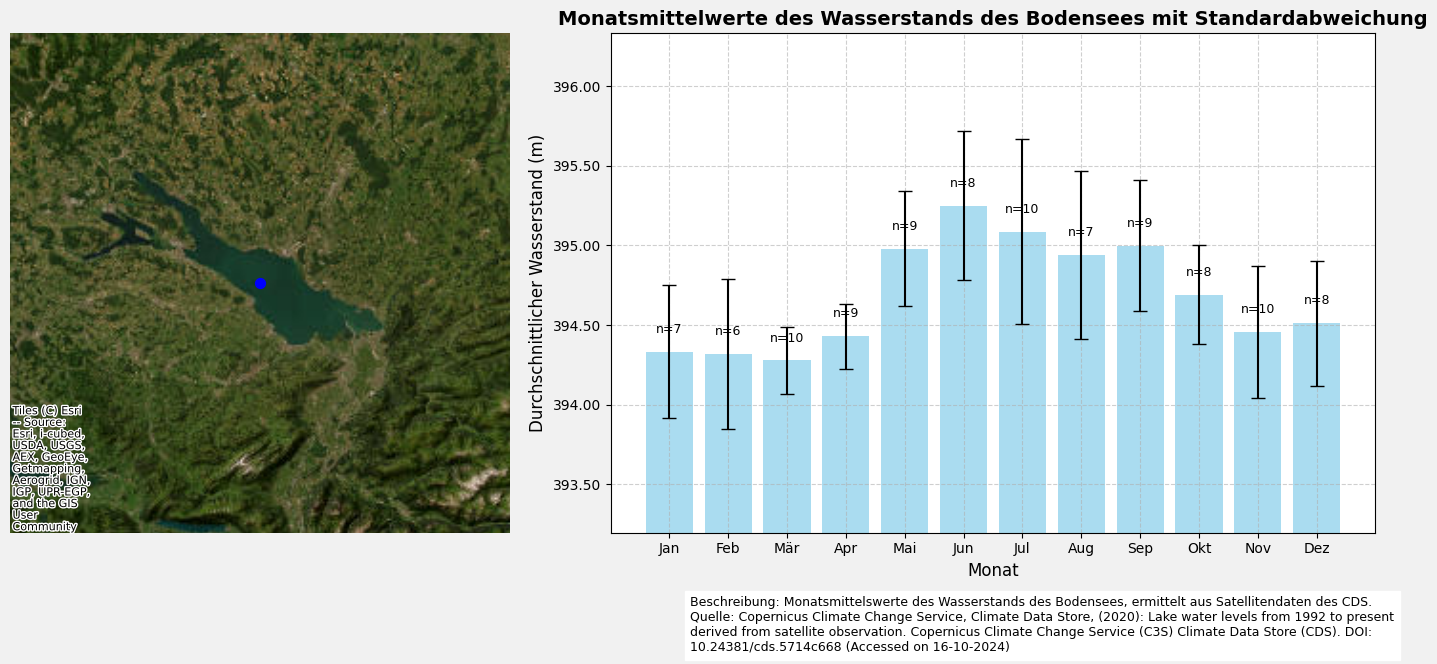

In [12]:
# Erstelle die Figur und die Achsen
fig, axs = plt.subplots(1,2, figsize=(14, 6), facecolor='#f1f1f1', edgecolor='k', gridspec_kw={'width_ratios': [1, 1.5]})

# --- 1. Karte des Bodensees ---
ax = axs[0]
lake_bodensee.plot(ax=ax, color='blue', markersize=50)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)  # Satellitenbild

# Passe den sichtbaren Bereich an (weiter herauszoomen)
# Erhöhe den Bereich für mehr Umgebung (hier auf 100 km in jede Richtung)
ax.set_xlim(lake_bodensee.geometry.x.min() - 80000, lake_bodensee.geometry.x.max() + 80000)  # Vergrößere den Bereich in x-Richtung
ax.set_ylim(lake_bodensee.geometry.y.min() - 80000, lake_bodensee.geometry.y.max() + 80000)  # Vergrößere den Bereich in y-Richtung

#ax1.set_title("Bodensee (Satellitenbild)")
ax.set_axis_off()  # Achsenbeschriftungen entfernen

# --- 2. Diagramm des Wasserstands ---
ax = axs[1]


# Balkenplot mit Standardabweichung als Fehlerbalken
bars = ax.bar(
    months, 
    monthly_mean, 
    yerr=monthly_std, 
    capsize=5, 
    color='skyblue', 
    alpha=0.7, 
    error_kw=dict(ecolor='black', lw=1.5)
)

# Setze den Bereich der Y-Achse von 390 bis 405
y_min = max(0, monthly_mean.min() - monthly_std.max() - 0.5)
y_max = monthly_mean.max() + monthly_std.max() + 0.5
ax.set_ylim(y_min, y_max)

# Setze die Achsentitel und die Diagrammüberschrift
ax.set_xlabel('Monat', fontsize=12)
ax.set_ylabel('Durchschnittlicher Wasserstand (m)', fontsize=12)
ax.set_title('Monatsmittelwerte des Wasserstands des Bodensees mit Standardabweichung', fontsize=14, fontweight='bold')

# Setze die X-Achsenbeschriftungen (1 = Januar, 12 = Dezember)
ax.set_xticks(months)
ax.set_xticklabels(month_labels)

# Füge den Stichprobenumfang n über den Balken hinzu
for bar, n in zip(bars, monthly_n):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.1,  # Adjusted to dynamically place above bar
        f'n={n}',
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )
    
# Füge ein Gitternetz hinzu
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Beschreibung und Quelle hinzufügen
plt.figtext(0.5, -0.05, 
            'Beschreibung: Monatsmittelswerte des Wasserstands des Bodensees, ermittelt aus Satellitendaten des CDS.\n'
            'Quelle: Copernicus Climate Change Service, Climate Data Store, (2020): Lake water levels from 1992 to present derived from satellite observation. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.5714c668 (Accessed on 16-10-2024)', 
            ha='left', va='center', fontsize=9, wrap=True, backgroundcolor='w')

# Zeige das Diagramm an
plt.tight_layout()
plt.show()